#### Spotify datasets analysis

In [1052]:
import numpy as np
import seaborn as sns
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import ast
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

from datetime import timedelta
import tensorflow
import numpy as np
from tensorflow.keras.models import Sequential

## Modèles de prédiction
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

## Calculateur de score
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

In [1053]:
### DATASET LOADING

spectral = pd.read_csv("spectral_features.tsv", sep="\t" )
echonest = pd.read_csv("echonest_features.tsv", sep="\t" )
tracks = pd.read_csv("tracks.tsv", sep="\t" )
genres = pd.read_csv("genres.csv")

In [1054]:
### DATASET PREVIEW
print(" ---- Nas details ---- ")
print(f" Number of Na variables for the spectral dataset : {spectral.isna().sum().sum()}, {spectral.shape}")
print(f" Number of Na variables for the echonest dataset : {echonest.isna().sum().sum()}, {echonest.shape}")
print(f" Number of Na variables for the tracks dataset : {tracks.isna().sum().sum()}, {tracks.shape}")
print(f" Number of Na variables for the genres dataset : {genres.isna().sum().sum()}, {genres.shape}")
print(" ---- Duplicates details ---- ")
print(f" Number of duplicates variables for the spectral dataset : {spectral.duplicated().sum()} {spectral.shape}")
print(f" Number of duplicates variables for the echonest dataset : {echonest.duplicated().sum()} {echonest.shape}")
print(f" Number of duplicates variables for the tracks dataset : {tracks.duplicated().sum()} {tracks.shape}")
print(f" Number of duplicates variables for the genres dataset : {genres.duplicated().sum()} {genres.shape}")


#print(f" Details about tracks missing values : \n {tracks.isna().sum()}")

 ---- Nas details ---- 
 Number of Na variables for the spectral dataset : 0, (99995, 22)
 Number of Na variables for the echonest dataset : 190, (11440, 9)
 Number of Na variables for the tracks dataset : 175850, (99995, 14)
 Number of Na variables for the genres dataset : 13, (164, 5)
 ---- Duplicates details ---- 
 Number of duplicates variables for the spectral dataset : 0 (99995, 22)
 Number of duplicates variables for the echonest dataset : 0 (11440, 9)
 Number of duplicates variables for the tracks dataset : 0 (99995, 14)
 Number of duplicates variables for the genres dataset : 0 (164, 5)


In [1055]:
#### Deletion of data columns with more than 60% of missing values

def cols_high_missing_values(df):
    cols = []
    for col in df.columns:
        print(f" Col {col} : {df[col].isna().sum() / df.shape[0]} number of missing values")
        if ( df[col].isna().sum() / df.shape[0] ) > 0.5:
            cols.append(col)
    return cols

#cols_remove = cols_high_missing_values(tracks)
#tracks.drop(columns=cols_remove, inplace=True)

#### DataSet Fusion & Cleaning

In [1056]:
print((echonest.columns).intersection(spectral.columns))
print((echonest.columns).intersection(tracks.columns))
print((spectral.columns).intersection(tracks.columns))

Index(['track_id'], dtype='object')
Index(['track_id'], dtype='object')
Index(['track_id'], dtype='object')


In [1057]:
echo_spec = pd.merge(echonest, spectral, on="track_id", how="outer")


In [1058]:
print((echo_spec.columns).intersection(tracks.columns))

df_fusion = pd.merge(echo_spec, tracks, on="track_id", how="outer")
cols_remove = cols_high_missing_values(df_fusion)
print(cols_remove)
df_fusion.shape

Index(['track_id'], dtype='object')
 Col track_id : 0.0 number of missing values
 Col acousticness : 0.8866001863563371 number of missing values
 Col danceability : 0.8867885252076684 number of missing values
 Col energy : 0.8866001863563371 number of missing values
 Col instrumentalness : 0.8866001863563371 number of missing values
 Col liveness : 0.8866001863563371 number of missing values
 Col speechiness : 0.8880870720247418 number of missing values
 Col tempo : 0.8866001863563371 number of missing values
 Col valence : 0.8868083503499138 number of missing values
 Col spectral_bandwidth_kurtosis_01 : 0.008792450585832954 number of missing values
 Col spectral_bandwidth_max_01 : 0.008792450585832954 number of missing values
 Col spectral_bandwidth_mean_01 : 0.008792450585832954 number of missing values
 Col spectral_bandwidth_median_01 : 0.008792450585832954 number of missing values
 Col spectral_bandwidth_min_01 : 0.008792450585832954 number of missing values
 Col spectral_bandwidt

(100882, 43)

In [1059]:
df_fusion.drop(columns=["artist_longitude", "artist_latitude"], inplace=True)
print(f"Number of Nas in df_fusion : {df_fusion.isna().sum()}")
df_fusion.shape

Number of Nas in df_fusion : track_id                              0
acousticness                      89442
danceability                      89461
energy                            89442
instrumentalness                  89442
liveness                          89442
speechiness                       89592
tempo                             89442
valence                           89463
spectral_bandwidth_kurtosis_01      887
spectral_bandwidth_max_01           887
spectral_bandwidth_mean_01          887
spectral_bandwidth_median_01        887
spectral_bandwidth_min_01           887
spectral_bandwidth_skew_01          887
spectral_bandwidth_std_01           887
spectral_centroid_kurtosis_01       887
spectral_centroid_max_01            887
spectral_centroid_mean_01           887
spectral_centroid_median_01         887
spectral_centroid_min_01            887
spectral_centroid_skew_01           887
spectral_centroid_std_01            887
spectral_rolloff_kurtosis_01        887
spectral_ro

(100882, 41)

In [1060]:
df_fusion['genre_top'].value_counts(dropna=False)

genre_top
NaN                    56249
Rock                   12085
Experimental            9752
Electronic              8769
Hip-Hop                 3334
Folk                    2375
Pop                     2235
Instrumental            2003
International           1256
Classical               1129
Old-Time / Historic      491
Jazz                     484
Spoken                   323
Country                  163
Soul-RnB                 131
Blues                     79
Easy Listening            24
Name: count, dtype: int64

In [1061]:
df = df_fusion[df_fusion["genres_all"] == "[2, 38, 107, 79, 1235]"]
df.head(50)

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,spectral_bandwidth_kurtosis_01,...,album_tracks,artist_name,duration,favorites,genre_top,genres,genres_all,interest,listens,title
181,12100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.281534,...,7.0,Selva de Mar,606.0,5.0,NaN,"[38, 79, 107]","[2, 38, 107, 79, 1235]",1759.0,1501.0,San Marti
182,12101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.584780,...,7.0,Selva de Mar,664.0,9.0,NaN,"[38, 79, 107]","[2, 38, 107, 79, 1235]",3044.0,2718.0,Heidi in Africa
183,12102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.290735,...,7.0,Selva de Mar,562.0,13.0,NaN,"[38, 79, 107]","[2, 38, 107, 79, 1235]",6285.0,4090.0,Gulab Jaman
184,12103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.266920,...,7.0,Selva de Mar,455.0,14.0,NaN,"[38, 79, 107]","[2, 38, 107, 79, 1235]",3485.0,3022.0,Philip's Glass
185,12104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.837944,...,7.0,Selva de Mar,493.0,5.0,NaN,"[38, 79, 107]","[2, 38, 107, 79, 1235]",2078.0,1757.0,Medusa
186,12105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.153168,...,7.0,Selva de Mar,360.0,14.0,NaN,"[38, 79, 107]","[2, 38, 107, 79, 1235]",2713.0,2505.0,Hipozebra
187,12106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.193884,...,7.0,Selva de Mar,369.0,12.0,NaN,"[38, 79, 107]","[2, 38, 107, 79, 1235]",3878.0,3501.0,Petra
7648,22570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.554963,...,8.0,Selva de Mar,284.0,6.0,NaN,"[38, 79, 107]","[2, 38, 107, 79, 1235]",1625.0,1066.0,TEMA CLUB EDEN #3
7649,22571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.483707,...,8.0,Selva de Mar,529.0,4.0,NaN,"[38, 79, 107]","[2, 38, 107, 79, 1235]",2155.0,1207.0,TIEMPO REAL
7650,22572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.796309,...,8.0,Selva de Mar,859.0,9.0,NaN,"[38, 79, 107]","[2, 38, 107, 79, 1235]",4917.0,2958.0,WALKING & TALKING


In [1062]:
#ON COMBLE LES VALEURS MANQUANTES DE genre_top
import pandas as pd
from collections import Counter
import random

#df=df_keep.copy()
df=df_fusion.copy()
# Mapping genre_id -> genre_parent_id
genre_parent_map = dict(zip(genres['genre_id'], genres['genre_parent_id']))
# Mapping genre_id -> genre_title
genre_title_map  = dict(zip(genres['genre_id'], genres['genre_title']))

def infer_top_genre_title(row):
    # garder si déjà présent et non vide

    if pd.isna(row['genres_all']):
        print(" hellooooo ")
        return "Unknown"
    
    if pd.notna(row['genre_top']):
        return row['genre_top']
    else:
        genre_ids = ast.literal_eval(row['genres_all'])
        if genre_ids == []:
            print("byeeeeeeee")
            return "Unknown"
    
    # récupérer les parents présents
    parents_in_all = [gid for gid in genre_ids if gid in genre_parent_map.values() and gid is not None]
    
    if parents_in_all:
        parent_counts = Counter(parents_in_all)
        most_common_count = parent_counts.most_common(1)[0][1]
        top_candidates = [p for p, count in parent_counts.items() if count == most_common_count]
        # choix aléatoire si plusieurs parents avec la même fréquence
        top_parent_id = random.choice(top_candidates)
        return genre_title_map.get(top_parent_id, "Unknown")
    else:
        # aucun parent → prendre le premier genre spécifique
        return genre_title_map.get(genre_ids[0], "Unknown")

# Appliquer sur le dataset
df_fusion['genre_top'] = df.apply(lambda x : infer_top_genre_title(x), axis=1)
print(df_fusion.shape)
df_fusion['genre_top'].value_counts()

byeeeeeeee
byeeeeeeee
byeeeeeeee
 hellooooo 
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
 hellooooo 
 hellooooo 
 hellooooo 
byeeeeeeee
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
byeeeeeeee
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 
 hellooooo 

genre_top
Experimental           21683
Electronic             19968
Rock                   19025
Pop                     6829
Folk                    6215
Hip-Hop                 5447
Unknown                 3025
International           2561
Classical               2410
Instrumental            2003
Soundtrack              1934
Jazz                    1883
Punk                     892
Country                  864
Spoken                   830
Blues                    664
Soul-RnB                 583
Old-Time / Historic      492
Techno                   350
Post-Rock                342
Easy Listening           294
Garage                   290
House                    243
Chip Music               233
Funk                     219
Loud-Rock                193
Noise-Rock               186
Metal                    179
Novelty                  169
Reggae - Dub             166
Dubstep                  144
Europe                   135
Latin America            106
Hardcore                  70
Afri

In [1063]:
print(df_fusion.shape)
print(f"Number of duplicates : {df_fusion.isna().sum()}")
df_fusion.dropna(inplace=True)
df_fusion.shape

(100882, 41)
Number of duplicates : track_id                              0
acousticness                      89442
danceability                      89461
energy                            89442
instrumentalness                  89442
liveness                          89442
speechiness                       89592
tempo                             89442
valence                           89463
spectral_bandwidth_kurtosis_01      887
spectral_bandwidth_max_01           887
spectral_bandwidth_mean_01          887
spectral_bandwidth_median_01        887
spectral_bandwidth_min_01           887
spectral_bandwidth_skew_01          887
spectral_bandwidth_std_01           887
spectral_centroid_kurtosis_01       887
spectral_centroid_max_01            887
spectral_centroid_mean_01           887
spectral_centroid_median_01         887
spectral_centroid_min_01            887
spectral_centroid_skew_01           887
spectral_centroid_std_01            887
spectral_rolloff_kurtosis_01        887
spec

(10405, 41)

In [1064]:
df_fusion['genres'].explode().value_counts().head(40)

k = 9 

top_genres = set(df_fusion["genres"].head(k).index)

df_fusion['genre_clean'] = df_fusion['genres'].apply(
    lambda lst: [g if g in top_genres else 'other' for g in lst]
)

mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df_fusion['genre_clean'])

genre_df = pd.DataFrame(
    genre_encoded,
    columns=mlb.classes_,
    index=df_fusion.index
)


In [1065]:
#df_fusion.head()
df_numeric = df_fusion.drop(columns=["album_title", "artist_name", "title", "genres", "genres_all", "track_id", "album_tracks", "genre_clean"])
#df_numeric["genre_clean"]

In [1067]:
df_numeric.isna().sum()

acousticness                      0
danceability                      0
energy                            0
instrumentalness                  0
liveness                          0
speechiness                       0
tempo                             0
valence                           0
spectral_bandwidth_kurtosis_01    0
spectral_bandwidth_max_01         0
spectral_bandwidth_mean_01        0
spectral_bandwidth_median_01      0
spectral_bandwidth_min_01         0
spectral_bandwidth_skew_01        0
spectral_bandwidth_std_01         0
spectral_centroid_kurtosis_01     0
spectral_centroid_max_01          0
spectral_centroid_mean_01         0
spectral_centroid_median_01       0
spectral_centroid_min_01          0
spectral_centroid_skew_01         0
spectral_centroid_std_01          0
spectral_rolloff_kurtosis_01      0
spectral_rolloff_max_01           0
spectral_rolloff_mean_01          0
spectral_rolloff_median_01        0
spectral_rolloff_min_01           0
spectral_rolloff_skew_01    

In [1068]:
df_numeric.head()
df_numeric["genre_top"].value_counts()
enc = OneHotEncoder(handle_unknown='ignore')

genre_encoded = enc.fit_transform(df_numeric[["genre_top"]]).toarray()
genre_encoded_df = pd.DataFrame(genre_encoded, columns=enc.get_feature_names_out(["genre_top"]))
df_numeric = pd.concat([df_numeric.reset_index(drop=True), genre_encoded_df.reset_index(drop=True)], axis=1)
df_numeric.drop(columns=["genre_top"], inplace=True)


In [1069]:
df_numeric.shape

(10405, 69)

#### Variable description

<Axes: >

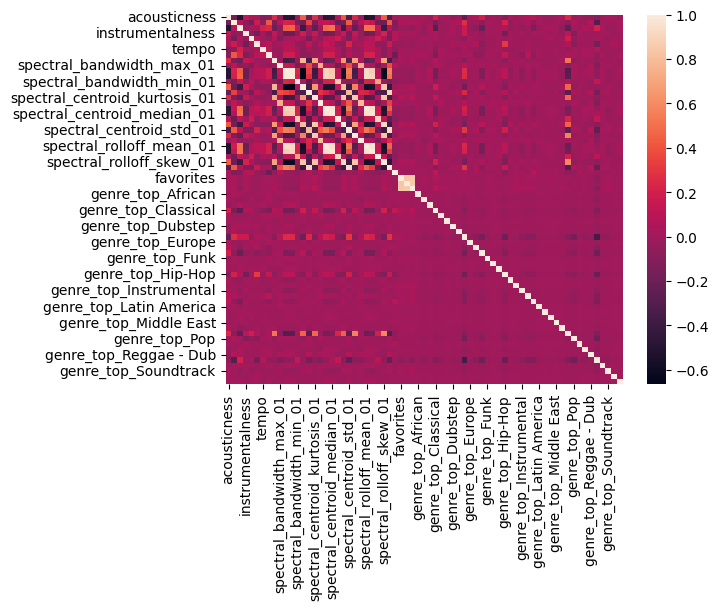

In [1070]:
corr_matrix = df_numeric.corr()
sns.heatmap(corr_matrix)

In [1071]:
df_numeric.columns

Index(['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence',
       'spectral_bandwidth_kurtosis_01', 'spectral_bandwidth_max_01',
       'spectral_bandwidth_mean_01', 'spectral_bandwidth_median_01',
       'spectral_bandwidth_min_01', 'spectral_bandwidth_skew_01',
       'spectral_bandwidth_std_01', 'spectral_centroid_kurtosis_01',
       'spectral_centroid_max_01', 'spectral_centroid_mean_01',
       'spectral_centroid_median_01', 'spectral_centroid_min_01',
       'spectral_centroid_skew_01', 'spectral_centroid_std_01',
       'spectral_rolloff_kurtosis_01', 'spectral_rolloff_max_01',
       'spectral_rolloff_mean_01', 'spectral_rolloff_median_01',
       'spectral_rolloff_min_01', 'spectral_rolloff_skew_01',
       'spectral_rolloff_std_01', 'duration', 'favorites', 'interest',
       'listens', 'genre_top_African', 'genre_top_Blues',
       'genre_top_Chip Music', 'genre_top_Classical', 'genre_top_Country',
       'genr

In [1072]:
cols_to_remove = ["spectral_centroid_max_01", "spectral_centroid_min_01", "spectral_centroid_skew_01"]
cols_to_remove += ["spectral_centroid_kurtosis_01", "spectral_centroid_median_01", "spectral_rolloff_max_01", "spectral_rolloff_min_01", "spectral_rolloff_median_01", "spectral_rolloff_kurtosis_01", "spectral_rolloff_skew_01"]
cols_to_remove += ["spectral_bandwidth_max_01", "spectral_bandwidth_min_01", "spectral_bandwidth_median_01", "spectral_bandwidth_kurtosis_01", "spectral_bandwidth_skew_01"]
cols_to_remove += ["spectral_centroid_mean_01", "spectral_centroid_std_01", "spectral_rolloff_mean_01", "spectral_rolloff_std_01"]
cols_to_remove += ["listens", "favorites"] #, "artist_latitude", "artist_longitude"]

df_numeric.drop(columns=cols_to_remove, inplace=True)
df_numeric.shape

(10405, 48)

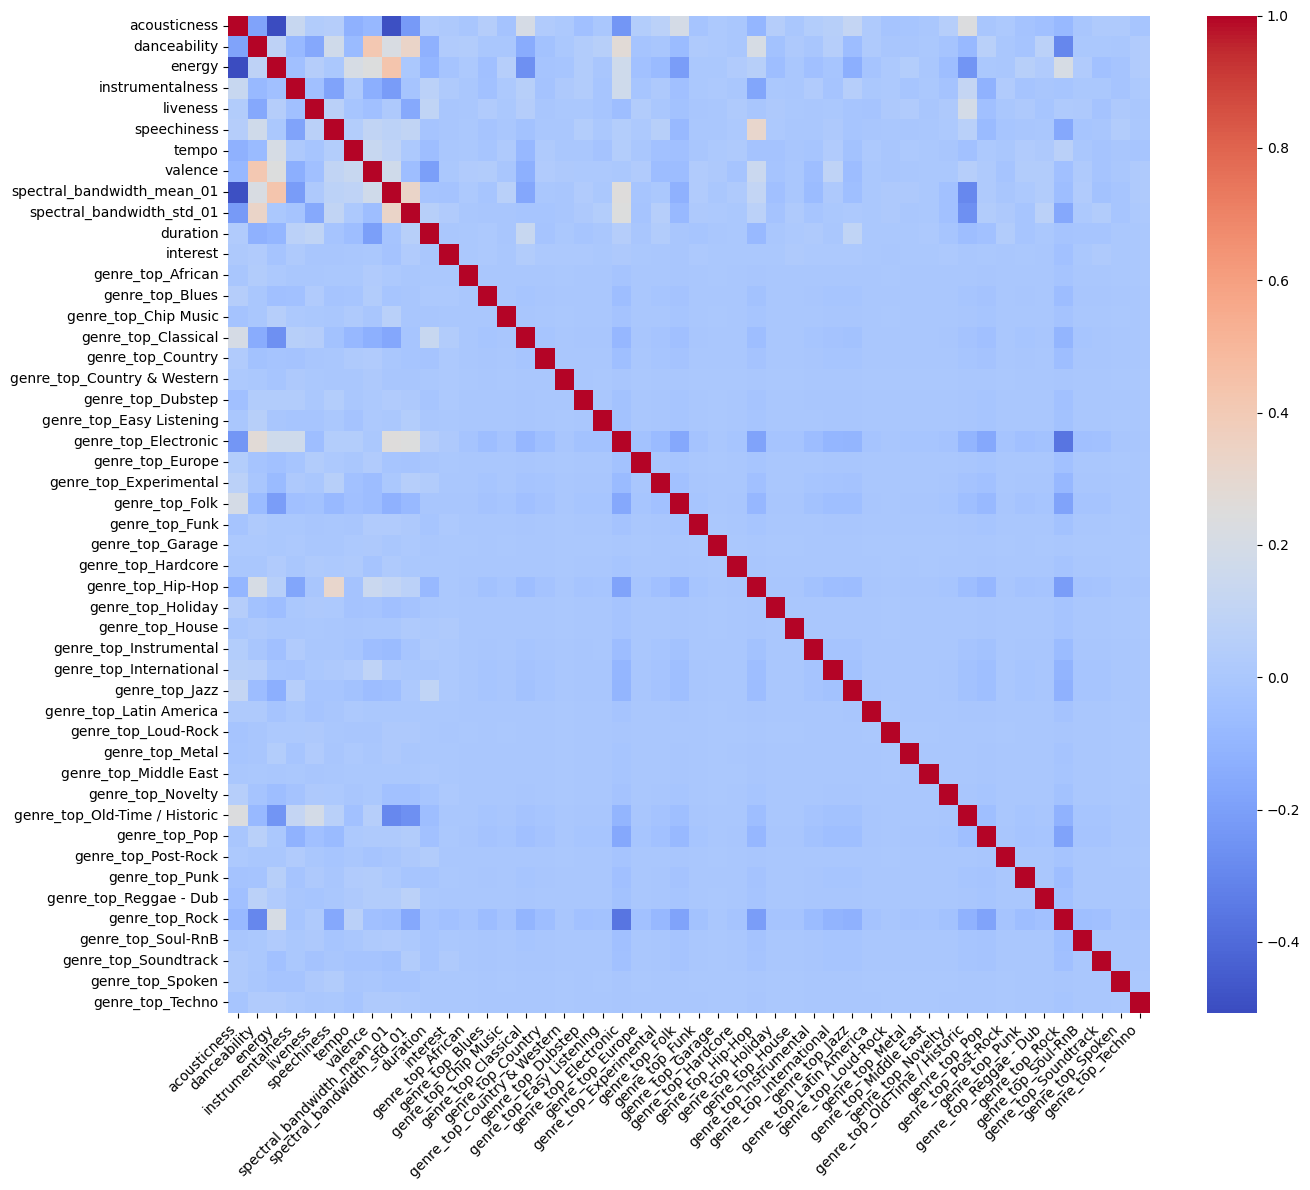

In [1073]:
corr_matrix = df_numeric.corr()


plt.figure(figsize=(14, 12))

sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=False,            # Set True if you want the correlation values printed
    xticklabels=True,
    yticklabels=True,
    cbar=True
)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### Model parameters

In [1074]:
from sklearn.model_selection import train_test_split

train, temp = train_test_split(df_numeric, test_size=0.3, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

In [1075]:
### TRAIN DATASET

X = train.drop(columns="duration")
y = train["duration"]

X_val = val.drop(columns="duration")
y_val = val["duration"]

X_test = test.drop(columns="duration")
y_test = test["duration"]

In [1076]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#### Model Training

In [1077]:
### Linear Regression

LR_model = LinearRegression()
LR_model.fit(X_scaled, y)
y_LR_pred = LR_model.predict(X_val_scaled)

LR_rmse_score = root_mean_squared_error(y_LR_pred, y_val)
LR_mae_score = mean_absolute_error(y_LR_pred, y_val)
LR_r2_score = r2_score(y_LR_pred, y_val)

print(f" LR - Root Mean Squared Error : {LR_rmse_score}")
print(f" LR - Mean Absolute Error : {LR_mae_score}")
print(f" LR - R2 Score : {LR_r2_score}")

 LR - Root Mean Squared Error : 168.7697685805355
 LR - Mean Absolute Error : 93.79714728109971
 LR - R2 Score : -8.08043565721462


In [1078]:
### KNN

KNN_model = KNeighborsRegressor(n_neighbors=5)
KNN_model.fit(X_scaled, y)
y_KNN_pred = KNN_model.predict(X_val_scaled)

KNN_rmse_score = root_mean_squared_error(y_KNN_pred, y_val)
KNN_mae_score = mean_absolute_error(y_KNN_pred, y_val)
KNN_r2_score = r2_score(y_KNN_pred, y_val)

print(f" KNN - Root Mean Squared Error : {KNN_rmse_score}")
print(f" KNN - Mean Absolute Error : {KNN_mae_score}")
print(f" KNN - R2 Score : {KNN_r2_score}")

 KNN - Root Mean Squared Error : 172.3241377640343
 KNN - Mean Absolute Error : 95.51415759128763
 KNN - R2 Score : -1.57470899500511


In [1079]:
### Decision Tree 

DT_model = DecisionTreeRegressor(random_state=42, max_depth=10)
DT_model.fit(X_scaled, y)
y_DT_pred = DT_model.predict(X_val_scaled)

DT_rmse_score = root_mean_squared_error(y_DT_pred, y_val)
DT_mae_score = mean_absolute_error(y_DT_pred, y_val)
DT_r2_score = r2_score(y_DT_pred, y_val)

print(f" DT - Root Mean Squared Error : {DT_rmse_score}")
print(f" DT - Mean Absolute Error : {DT_mae_score}")
print(f" DT - R2 Score : {DT_r2_score}")

 DT - Root Mean Squared Error : 214.39752835306928
 DT - Mean Absolute Error : 101.24354161423113
 DT - R2 Score : -0.953484419938641


In [1080]:
### Random Forest

RF_model = RandomForestRegressor(n_estimators=50, random_state=42)
RF_model.fit(X_scaled, y)
y_RF_pred = RF_model.predict(X_val_scaled)

RF_rmse_score = root_mean_squared_error(y_RF_pred, y_val)
RF_mae_score = mean_absolute_error(y_RF_pred, y_val)
RF_r2_score = r2_score(y_RF_pred, y_val)


print(f" RF - Root Mean Squared Error : {RF_rmse_score}")
print(f" RF - Mean Absolute Error : {RF_mae_score}")
print(f" RF - R2 Score : {RF_r2_score}")

 RF - Root Mean Squared Error : 173.49828703136728
 RF - Mean Absolute Error : 94.8414606021781
 RF - R2 Score : -2.240215992204949


In [1081]:
### XGB Regressor

XGB_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
XGB_model.fit(X_scaled, y)
y_XGB_pred = XGB_model.predict(X_val_scaled)

XGB_rmse_val = root_mean_squared_error(y_val, y_XGB_pred)
XGB_mae_val = mean_absolute_error(y_val, y_XGB_pred)
XGB_r2_val = r2_score(y_val, y_XGB_pred)

print(f"Validation RMSE (XGBoost): {XGB_rmse_val}")
print(f"Validation MAE (XGBoost): {XGB_mae_val}")
print(f"Validation R2 (XGBoost): {XGB_r2_val}")

Validation RMSE (XGBoost): 171.65856068055692
Validation MAE (XGBoost): 91.07689813861933
Validation R2 (XGBoost): 0.020350459836631418


In [1082]:
### Neural Network

MLP_model = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1500, random_state=42)
MLP_model.fit(X_scaled, y)
y_MLP_pred = MLP_model.predict(X_val_scaled)

MLP_rmse_val = root_mean_squared_error(y_val, y_MLP_pred)
MLP_mae_val = mean_absolute_error(y_val, y_MLP_pred)
MLP_r2_val = r2_score(y_val, y_MLP_pred)

print(f"Validation RMSE (MLP): {MLP_rmse_val}")
print(f"Validation MAE (MLP): {MLP_mae_val}")
print(f"Validation R2 (MLP): {MLP_r2_val}")

Validation RMSE (MLP): 164.8299670888703
Validation MAE (MLP): 90.06082236218164
Validation R2 (MLP): 0.09674130828683214


#### Results

In [1083]:
### RMSE Results

print(f" LR - Root Mean Squared Error : {LR_rmse_score}")
print(f" KNN - Root Mean Squared Error : {KNN_rmse_score}")
print(f" DT - Root Mean Squared Error : {DT_rmse_score}")
print(f" RF - Root Mean Squared Error : {RF_rmse_score}")
print(f"Validation RMSE (XGBoost): {XGB_rmse_val}")
print(f"Validation RMSE (MLP): {MLP_rmse_val}")

 LR - Root Mean Squared Error : 168.7697685805355
 KNN - Root Mean Squared Error : 172.3241377640343
 DT - Root Mean Squared Error : 214.39752835306928
 RF - Root Mean Squared Error : 173.49828703136728
Validation RMSE (XGBoost): 171.65856068055692
Validation RMSE (MLP): 164.8299670888703
